# Linearize Behavior

In [91]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import csv

#TODO: Translate linearized data to position


load_behavior = 'TimeSync/behavior_frames_02_03.npy'
load_t_behavior = 'TimeSync/t_behavior_02_03.npy'

behavior_frames = np.load(load_behavior)
behavior_frames = behavior_frames - 932 # Fixing because Behavior Tracking Started at 932
t_behavior = np.load(load_t_behavior)

In [257]:
csv_fname = "ezTrack/2023-02-03_LocationOutput.csv"

def load_behavior_file(csv_fname):
    # Load Raw Behavior Data
    file = open(csv_fname)
    csvreader = csv.reader(file)
    pos_x = []
    pos_y = []
    for row in csvreader:
        if row[7] != 'X': # skip the first row
            pos_x.append(float(row[7])) 
            pos_y.append(float(row[8]))

    # Removing Out of Sync Behavior Frames
    pos_x = [pos_x[f] for f in behavior_frames]
    pos_y = [pos_y[f] for f in behavior_frames]

    if len(t_behavior) < len(pos_x):
        pos_x = pos_x[0:len(t_behavior)]
        pos_y = pos_y[0:len(t_behavior)]

    print("Behavior Sync Frames = ", len(behavior_frames))
    print("Behavior Time Len = ", len(t_behavior))
    print("Num Frames:", len(pos_x), len(pos_y))

    fig = plt.figure(figsize=(4,4))
    ax = fig.gca()
    plt.plot(pos_x, pos_y)
    plt.title("Raw Behavior (n = "+ str(len(pos_x))+ ") \n" + csv_fname)
    # plt.title("Raw Behavior \n " + csv_fname)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()


In [253]:
def norm_rotate_behavior(pos_x, pos_y):
    # Normalize and transform raw position data in order to linearize
    pos_x_norm = (pos_x-np.min(pos_x))/(np.max(pos_x)-np.min(pos_x))
    pos_y_norm = (pos_y-np.min(pos_y))/(np.max(pos_y)-np.min(pos_y))
    
    # Rotate position data
    x = pos_y_norm
    y = 1 - pos_x_norm
    
    # Plotting new position data
    fig = plt.figure(figsize=(4,4))
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1.2, 0.1))
    ax.set_yticks(np.arange(0, 1.2, 0.1))
    plt.scatter(x, y)
    plt.grid()
    plt.title("Norm and Rotated Position Data")
    plt.show()
    
    return x, y


In [317]:
def transform_arm1(x,y):
    return y - 0.9

def transform_arm2(x,y):
    return 1.9 - y

def transform_center(x,y):
    return x

def linearize_behavior(x, y):
    # Linearize rotated/normalized behavior tracking data
    # Turn left and right arms outward before the corner begins
    # Corner is considered upper right and upper left 10th box

    arm1 = []
    arm2 = []
    corner1 = []
    corner2 = []
    center = []
    linearized_data = []
    category = []

    for i in range(len(x)):
        # Arm 1 Condition
        if x[i] < 0.1 and y[i] <= 0.9:
            cat = "arm1"
            arm1.append((x[i], y[i], t_behavior[i]))
            linearized_data.append((transform_arm1(x[i], y[i]),cat))
            category.append(1)

        # Corner 1 Condition
        elif x[i] < 0.1 and y[i] > 0.9:
            cat = "corner1"
            corner1.append((x[i], y[i], t_behavior[i]))
            linearized_data.append((transform_arm1(x[i], y[i]),cat))
            category.append(2)

        # Arm 2 Condition
        elif x[i] > 0.9 and y[i] <= 0.9:
            cat = "arm2"
            arm2.append((x[i], y[i], t_behavior[i]))
            linearized_data.append((transform_arm2(x[i], y[i]),cat))
            category.append(3)

        # Corner 2 Condition
        elif x[i] > 0.9 and y[i] > 0.9:
            cat = "corner2"
            corner2.append((x[i], y[i], t_behavior[i]))
            linearized_data.append((transform_arm2(x[i], y[i]),cat))
            category.append(4)

        else:
            # Center Condition
            cat = "center"
            center.append((x[i],y[i],t_behavior[i]))
            linearized_data.append((transform_center(x[i], y[i]),cat))
            category.append(5)

    # Sanity Check
    if(len(arm1) + len(corner1) + len(arm2) + len(corner2) + len(center) != len(x)):
        print("Error lengths not equal")
    if(len(linearized_data) != len(x)):
        print("Error in Length of Linearized Data")

    # Plot Sorted Behavior Position
    fig = plt.figure(figsize=(4,4))
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1.2, 0.1))
    ax.set_yticks(np.arange(0, 1.2, 0.1))
    plt.scatter([i for i,j,k in arm1],[j for i,j,k in arm1])
    plt.scatter([i for i,j,k in arm2],[j for i,j,k in arm2])
    plt.scatter([i for i,j,k in corner1],[j for i,j,k in corner1])
    plt.scatter([i for i,j,k in corner2],[j for i,j,k in corner2])
    plt.scatter([i for i,j,k in center],[j for i,j,k in center])
    plt.grid()
    plt.title("Sorted Behavior (n = "+ str(len(linearized_data))+ ")")
    plt.show()
    
    category = np.array(category)
    
    return linearized_data, category
    

In [252]:
def plot_linearized_data_category(data, category, color=None):
    # Plot category of linearized data
    # Inputs include data, category, and color (optional)
    # Choose from arm1, arm2, corner1, corner2, center
    plt.scatter([i for i,j in data if j == category], [1 for i,j in data if j == category], c=color)

def plot_linearized_behavior(data):
    fig = plt.figure(figsize=(8, 2))
    ax = fig.gca()
    ax.set_xticks(np.arange(-1, 2.1, 0.5))
    plot_linearized_data_category(data, 'arm1')  
    plot_linearized_data_category(data, 'arm2')
    plot_linearized_data_category(data, 'corner1')
    plot_linearized_data_category(data, 'corner2')
    plot_linearized_data_category(data, 'center')
    plt.xlim(-1,2)
    plt.ylim(0.9,1.1)
    ax.set_yticks([])
    plt.grid()
    plt.title("Linearized Behavior Position (n = "+ str(len(data))+ ")")
    plt.show()

Behavior Sync Frames =  26031
Behavior Time Len =  26030
Num Frames: 26030 26030


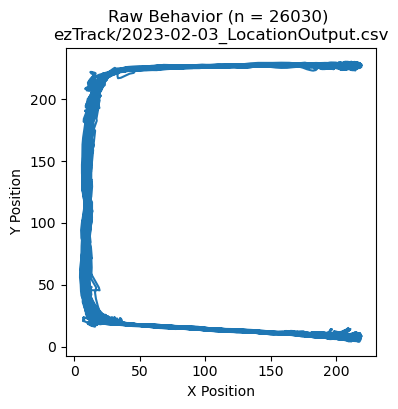

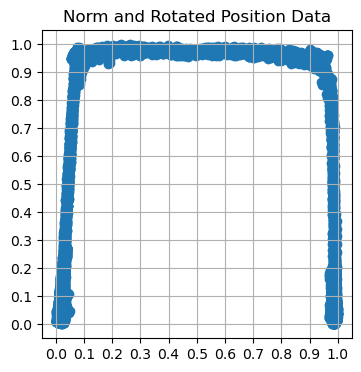

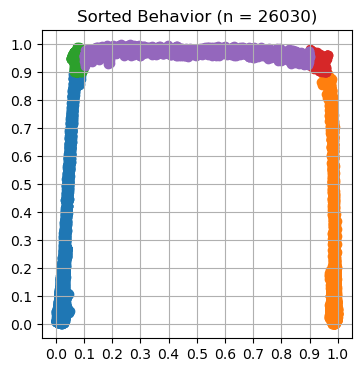

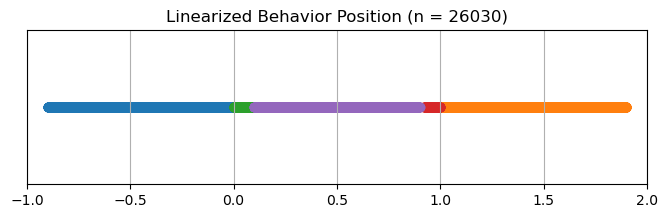

In [318]:

load_behavior_file(csv_fname)
x, y = norm_rotate_behavior(pos_x, pos_y)
linearized_data, category = linearize_behavior(x, y)
plot_linearized_behavior(linearized_data)

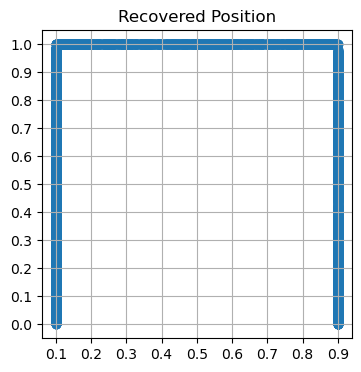

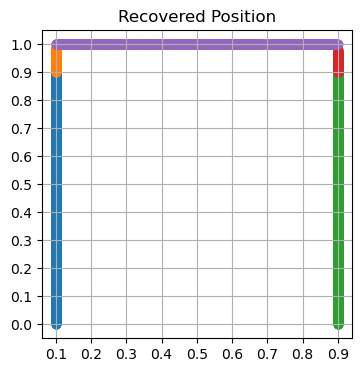

In [325]:
x_recovered = []
y_recovered = []

for i,j in linearized_data:
    if j == 'arm1' or j == 'corner1':
        x_recovered.append(0.1)
        y_recovered.append(i + 0.9)
        
    elif j == 'arm2' or j == 'corner2':
        x_recovered.append(0.9)
        y_recovered.append(-1*i + 1.9)

    elif j == 'center':
        x_recovered.append(i)
        y_recovered.append(1)

        
# Plotting new position data
fig = plt.figure(figsize=(4,4))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1.2, 0.1))
ax.set_yticks(np.arange(0, 1.2, 0.1))
plt.scatter(x_recovered, y_recovered)
plt.grid()
plt.title("Recovered Position")
plt.show()
    

# Plotting sorted position data
fig = plt.figure(figsize=(4,4))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1.2, 0.1))
ax.set_yticks(np.arange(0, 1.2, 0.1))

for c in range(1,6):
    plt.scatter([x_recovered[i] for i in range(len(category)) if category[i] == c], [y_recovered[i] for i in range(len(category)) if category[i] == c])


plt.grid()
plt.title("Recovered Position")
plt.show()
    

In [322]:
[x_recovered[i] for i in range(len(category)) if category[i] == 1]

# np.where(category == 1)

[0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1

In [321]:
x_recovered[np.where(category == 1)]

TypeError: list indices must be integers or slices, not tuple

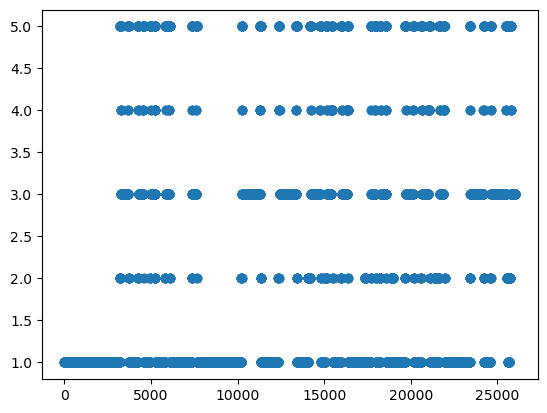

In [303]:
plt.scatter(range(len(category)),category)

# Junk

In [ ]:


# fig = plt.figure(figsize=(8, 2))
# ax = fig.gca()
# ax.set_xticks(np.arange(-1, 2.1, 0.5))
# plt.scatter([i for i,j in linearized_data if j == 'arm1'], [1 for i,j in linearized_data if j == 'arm1'], c='b')
# plt.scatter([i for i,j in linearized_data if j == 'corner1'], [1 for i,j in linearized_data if j == 'corner1'], c='orange')
# plt.scatter([i for i,j in linearized_data if j == 'arm2'], [1 for i,j in linearized_data if j == 'arm2'], c='g')
# plt.scatter([i for i,j in linearized_data if j == 'corner2'], [1 for i,j in linearized_data if j == 'corner2'], c='r')
# plt.scatter([i for i,j in linearized_data if j == 'center'], [1 for i,j in linearized_data if j == 'center'], c='purple')
# plt.xlim(-1,2)
# plt.ylim(0.9,1.1)
# ax.set_yticks([])
# plt.grid()
# plt.title("Linearized Behavior Position")
# plt.show()


# def plot_linearized_behavior():
#     fig = plt.figure(figsize=(8, 2))
#     ax = fig.gca()
#     ax.set_xticks(np.arange(-1, 2.1, 0.5))
#     plt.scatter([j - 0.9 for i,j,k in arm1],[1 for i,j,k in arm1])
#     plt.scatter([1.9 - j for i,j,k in arm2],[1 for i,j,k in arm2])
#     plt.scatter([j - 0.9 for i,j,k in corner1],[1 for i,j,k in corner1])
#     plt.scatter([1.9 - j for i,j,k in corner2],[1 for i,j,k in corner2])
#     plt.scatter([i for i,j,k in center],[1 for i,j,k in center])
#     plt.xlim(-1,2)
#     plt.ylim(0.9,1.1)
#     ax.set_yticks([])
#     plt.grid()
#     plt.title("Linearized Behavior Position")
#     plt.show()

# plot_linearized_behavior()